In [151]:
#Includes necesarios
from sklearn.naive_bayes import GaussianNB,CategoricalNB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV,train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction,plot_cm,plot_tree
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,plot_roc_curve,roc_auc_score
import preprocessing as pr

# **Ensamble Naive Bayes**

Vamos a realizar un ensamble con los siguientes modelos: 

    - GuassianNB: para aquellas columnas numericas
    - CategoricalNB: para aquellas columnas categoricas

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [152]:
X,y = get_train_set()
X = pr.init_dataset(X)

## Gaussian Naive Bayes

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas continuas. En este caso no nos hace falta aplicar OHE, puesto que todas las columnas que nos quedan son numericas. Tampoco nos sirve los preprocesamientos de reduccion por frecuencia o discretizacion, puesto que esto eliminaria o generaria nuevas columnas categoricas.

In [153]:
X_continuos = X.select_dtypes(include=['int64','int32'])
X_continuos.head()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas
0,17,39,2174,40
1,17,50,0,13
2,13,38,0,40
3,11,53,0,40
4,17,28,0,40


Ahora realizamos un escalado a nuestras columnas continuas. El rango de escalado es entre (0,1):

In [154]:
X_p2 = pr.scale(X_continuos)
X_p2

array([[0.84210526, 0.30136986, 0.06257486, 0.39795918],
       [0.84210526, 0.45205479, 0.04174213, 0.12244898],
       [0.63157895, 0.28767123, 0.04174213, 0.39795918],
       ...,
       [0.63157895, 0.56164384, 0.04174213, 0.39795918],
       [0.63157895, 0.06849315, 0.04174213, 0.19387755],
       [0.63157895, 0.47945205, 0.18571223, 0.39795918]])

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [155]:
X_train, X_validation, y_train, y_validation = train_test_split(X_p2,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para el modelo gaussiano con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [156]:
parameters = {
    'var_smoothing': np.arange(0, 0.0000001,0.00000001)
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8362074494200744
Mejores Parametros {'var_smoothing': 9e-08}

Mejor score ROC-AUC en Validación: 0.8343854465446441


Aramamos el modelo de GaussianNB con los hiperparametros calculados:

In [157]:
model_gaussianNB = gscv.best_estimator_
model_gaussianNB

GaussianNB(var_smoothing=9e-08)

Predecimos con el validation set:

In [158]:
gaussianNB_predict = model_gaussianNB.predict_proba(X_validation)

In [159]:
gaussianNB_predict

array([[0.97742787, 0.02257213],
       [0.99490779, 0.00509221],
       [0.95725864, 0.04274136],
       ...,
       [0.99489166, 0.00510834],
       [0.00134999, 0.99865001],
       [0.38609392, 0.61390608]])

## Categorical Naive Bayes

Para aplicar este tipo de modelo debemos quedarnos solo con columnas categoricas para luego aplicar Ordinal Encoder (ODE).

In [160]:
X_category = X.select_dtypes(include=['category'])
X_category.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado


Ahora reduciremos por frecuencia de aparicion algunas columnas y luego aplicaremos ODE a las columnas categoricas. Reduciremos mediante la funcion **reduce_by_frequency_occurrence** que por predeterminado tiene las columnas *Barrio, Religion, Categoria de Trabajo, Estado Marital*:

In [161]:
columns = ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital']
X_p1 = pr.reduce_by_frequency(X_category,columns,0.15)
X_ode = pr.apply_ODE(X_p1)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [162]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ode,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para el modelo categoricalNB con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [163]:
parameters = {
    'alpha': np.arange(0, 1,0.01),
}

clf = CategoricalNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Mejor score ROC-AUC en Entrenamiento: {gscv.best_score_}")
print(f"Mejores Parametros {gscv.best_params_}")

print(f"\nMejor score ROC-AUC en Validación: {gscv.score(X_validation, y_validation)}")

Mejor score ROC-AUC en Entrenamiento: 0.8471068940906367
Mejores Parametros {'alpha': 0.2}

Mejor score ROC-AUC en Validación: 0.8388703674088442


Aramamos el modelo de CategoricalNB con los hiperparametros calculados:

In [164]:
model_categoricalNB = gscv.best_estimator_
model_categoricalNB

CategoricalNB(alpha=0.2)

Predecimos con el validation set:

In [165]:
categoricalNB_predict_train = model_categoricalNB.predict_proba(X_train)
categoricalNB_predict = model_categoricalNB.predict_proba(X_validation)

In [166]:
categoricalNB_predict

array([[0.23592686, 0.76407314],
       [0.99724066, 0.00275934],
       [0.9609985 , 0.0390015 ],
       ...,
       [0.99704393, 0.00295607],
       [0.87217659, 0.12782341],
       [0.23205131, 0.76794869]])

## Realizando el Ensamble

In [167]:
def ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict):
    predictions_proba = []
    for idx,fila in enumerate(gaussianNB_predict):
        maximum_value_gaussian = np.amax(fila, 0)
        maximum_value_categorical = np.amax(categoricalNB_predict[idx], 0)
        if(maximum_value_gaussian >= maximum_value_categorical):
            predictions_proba.append(fila)
        else:
            predictions_proba.append(categoricalNB_predict[idx])
    predictions_proba = [l.tolist() for l in predictions_proba]
    return predictions_proba

In [168]:
def ensamble_predict(gaussianNB_predict, categoricalNB_predict):
    predictions = []
    predictions_proba = ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict)
    for prediction in np.array(predictions_proba)[:, 1]:
        if(prediction > 0.5):
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [169]:
ensambleNB_predict = ensamble_predict(gaussianNB_predict, categoricalNB_predict)

**Metricas**

In [170]:
print(classification_report(y_validation,ensambleNB_predict))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4945
           1       0.77      0.32      0.45      1568

    accuracy                           0.81      6513
   macro avg       0.80      0.65      0.67      6513
weighted avg       0.81      0.81      0.78      6513



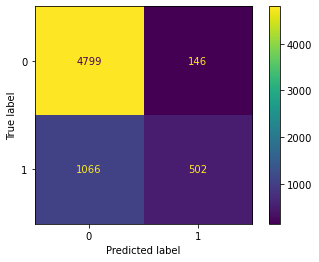

In [171]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_validation,ensambleNB_predict))
cm.plot()

In [172]:
roc_auc = roc_auc_score(y_validation, np.array(ensamble_predict_proba(gaussianNB_predict, categoricalNB_predict))[:, 1])
print(f"\nMejor score ROC-AUC en Validación: {roc_auc}")


Mejor score ROC-AUC en Validación: 0.8744335006500072


# Conclusión

Vimos que usando unicamente el modelo gaussiano o el modelo categorical tenemos una mal performance en la metrica *roc_auc*. Ahora si juntamos las predicciones de ambos mediante un ensamble tenemos una mejora de dicha metrica aunque no llega a ser uno de los mejores modelos que tenemos.

# Predicción

Por ultimo, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [173]:
ids, X_holdout = get_holdout_set()
X_holdout = pr.init_dataset(X_holdout)

In [174]:
X_holdout_continuos = X_holdout.select_dtypes(include=['int64','int32'])
X_holdout_categorical = X_holdout.select_dtypes(include=['category'])

X_holdout_continuos = pr.scale(X_holdout_continuos)
columns = ['barrio', 'religion', 'categoria_de_trabajo', 'estado_marital']
X_holdout_categorical = pr.reduce_by_frequency(X_holdout_categorical,columns,0.15)
X_holdout_categorical = pr.apply_ODE(X_holdout_categorical)

gaussian_predict = model_gaussianNB.predict_proba(X_holdout_continuos)
categorical_predict = model_categoricalNB.predict_proba(X_holdout_categorical)
ensambleNB_predict = ensamble_predict(gaussian_predict,categorical_predict)

In [175]:
create_prediction(ids,ensambleNB_predict,file_name='ensambleNB')